In [3]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns
import datetime
import statistics
import math
from scipy.stats import t
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import ttest_1samp, shapiro, anderson
from scipy.stats import t, probplot, ks_2samp, anderson_ksamp
from scipy.optimize import minimize
import scipy.optimize as opt
from scipy.stats import laplace

from fitter import Fitter, get_common_distributions, get_distributions

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
df_2009 = pd.read_csv("2009_FINAL.csv")
df_2014 = pd.read_csv("2014_FINAL.csv")
df_2019 = pd.read_csv("2019_FINAL.csv")

# 2009 Analysis

In [12]:
df_2009['vol_difference'] = df_2009['impvol_1month_ATM'] - df_2009['impvol_6month_ATM']
positive_count = (df_2009['vol_difference'] > 0).sum()
print("Number of positive numbers:", positive_count)

Number of positive numbers: 3482


In [13]:
df_2009['actual-predicted_model1'] = df_2009.apply(
    lambda row:  abs(row['log_returns']*100) - (np.sqrt(2/math.pi)* ((np.sqrt((row['impvol_1month_ATM']**2) - (row['impvol_6month_ATM']**2))) * np.sqrt(1/12)))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2009['actual-predicted_model2'] = df_2009.apply(
    lambda row:  abs(row['log_returns']*100) - (row['vol_difference'] * np.sqrt(1/12))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2009

,event_id,company_id,stock_symbol,company_name,announce_datetime,fiscal_year,quarter,quarter_end_date,currency,amount_oc,time_class,announce_date,log_returns,impvol_1month_ATM,impvol_6month_ATM,vol_difference,actual-predicted_model1,actual-predicted_model2
0,3NN7AOIC,7785,NEOG,Neogen Corporation,2009-01-06 08:45:00,2009,Q2,11/30/2008,USD,0.26,BMO,2009-01-06,0.019426,71.8678,61.9152,9.9526,-6.464190,-0.930505
1,3NN74QQF,1431681901,AYI,Acuity Brands Inc.,2009-01-06 08:47:00,2009,Q1,11/30/2008,USD,0.48,BMO,2009-01-06,0.006202,86.7289,59.0580,27.6709,-14.012657,-7.367656
2,3NN7COBS,2446,SMSC,Standard Microsystems Corporation,2009-01-06 16:00:00,2009,Q3,11/30/2008,USD,0.39,AMC,2009-01-06,-0.111261,NaN,NaN,NaN,NaN,NaN
3,3NN78KRS,1431664636,GPN,"Global Payments, Inc.",2009-01-06 16:01:00,2009,Q2,11/30/2008,USD,0.60,AMC,2009-01-06,-0.044687,78.6194,53.8953,24.7241,-8.718473,-2.668529
4,3NN78CG1,985,FINL,"The Finish Line, Inc.",2009-01-06 16:15:00,2009,Q3,11/29/2008,USD,-0.16,AMC,2009-01-06,-0.057377,168.2129,97.8846,70.3283,-25.779299,-14.564320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,3NN78CG5,985,FINL,"The Finish Line, Inc.",2009-12-22 16:30:00,2010,Q3,11/28/2009,USD,0.12,AMC,2009-12-22,0.089841,61.1786,53.0305,8.1481,1.955968,6.631917
4612,3NN7C6T2,2012,PNY,Piedmont Natural Gas,2009-12-23 08:47:00,2009,Q4,10/31/2009,USD,NaN,BMO,2009-12-23,0.007590,20.1123,22.3004,-2.1881,NaN,NaN
4613,3NN75AL8,8072,CALM,Cal-Maine Foods Inc,2009-12-28 06:30:00,2010,Q2,11/28/2009,USD,0.67,BMO,2009-12-28,0.006148,43.2193,35.2440,7.9753,-5.148446,-1.687482
4614,3NN7ATX9,2110,NX,Quanex Building Products Corp.,2009-12-03 17:01:00,2009,Q4,10/31/2009,USD,0.41,AMC,2009-12-03,0.051960,45.9906,48.8929,-2.9023,NaN,NaN


### 2009 price jump 

mean 0.002 std 0.061
2 sigma -0.120 and 0.124
The percentage of companies outside 2 sigma is 5.394%
The 10th percentile point is -0.064
The 90th percentile point is 0.068


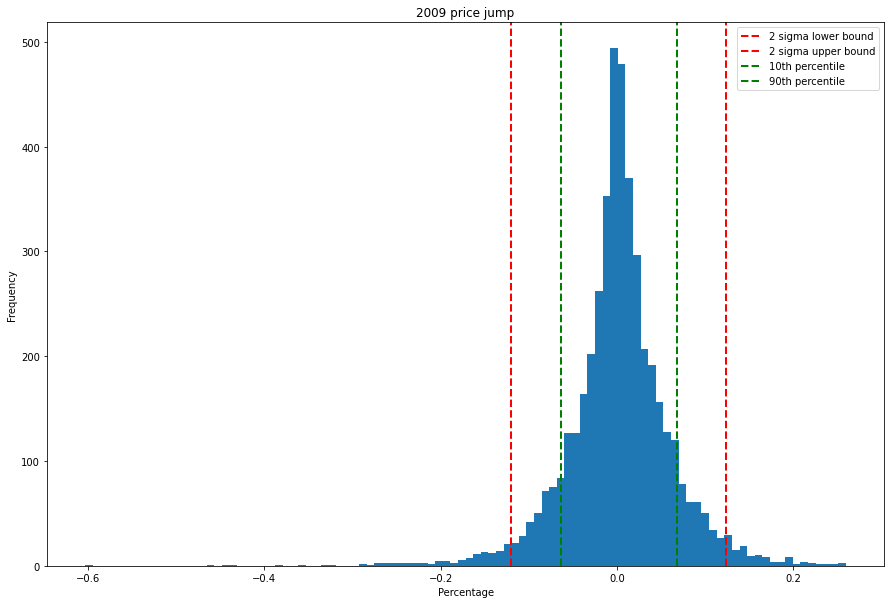

In [14]:
#drop NaN values
data = df_2009['log_returns'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Create a df with only the tail events
events_outside_2_sigma = outside_2_sigma.tolist()
tail_data_2009 = df_2009[df_2009['log_returns'].isin(outside_2_sigma)]

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 price jump')

plt.show()

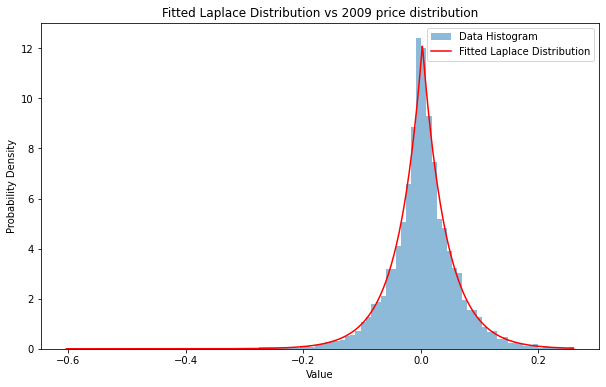

Kolmogorov-Smirnov Test:
KS Statistic: 0.017
P-value: 0.128
Mean Squared Error (MSE): 51.167


In [15]:
loc, scale = stats.laplace.fit(data)
plt.figure(figsize=(10, 6))
plt.hist(data, bins=100, density=True, alpha=0.5, label="Data Histogram")
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.pdf(x, loc=loc, scale=scale)

plt.plot(x, laplace_dist, 'r', label="Fitted Laplace Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Fitted Laplace Distribution vs 2009 price distribution")
plt.legend()
plt.show()

#Performing Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = stats.kstest(data, 'laplace', args=(loc, scale))
print("Kolmogorov-Smirnov Test:")
print(f"KS Statistic: {ks_statistic:.3f}")
print(f"P-value: {ks_p_value:.3f}")

#Calculate the Mean Squared Error
fitted_values = stats.laplace.pdf(data, loc=loc, scale=scale)
mse = np.mean((data - fitted_values) ** 2)

print(f"Mean Squared Error (MSE): {mse:.3f}")

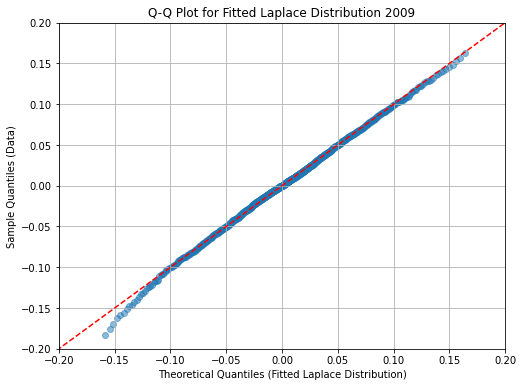

In [16]:
#Fiting the Laplace distribution to the data
loc, scale = stats.laplace.fit(data)

#Generate values for the fitted Laplace distribution
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.ppf(np.linspace(0.01, 0.99, 1000), loc=loc, scale=scale)

quantiles_data = np.percentile(data, np.linspace(1, 99, 1000))

#Plot the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(laplace_dist, quantiles_data, alpha=0.5)
plt.plot([np.min(data), np.max(data)], [np.min(data), np.max(data)], 'r--')
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Theoretical Quantiles (Fitted Laplace Distribution)')
plt.ylabel('Sample Quantiles (Data)')
plt.title('Q-Q Plot for Fitted Laplace Distribution 2009')
plt.grid(True)
plt.show()



### 2009 model 1 

mean -5.816 std 8.840
2 sigma -23.496 and 11.864
The percentage of companies outside 2 sigma is 5.026%
The 10th percentile point is -16.469
The 90th percentile point is 2.002


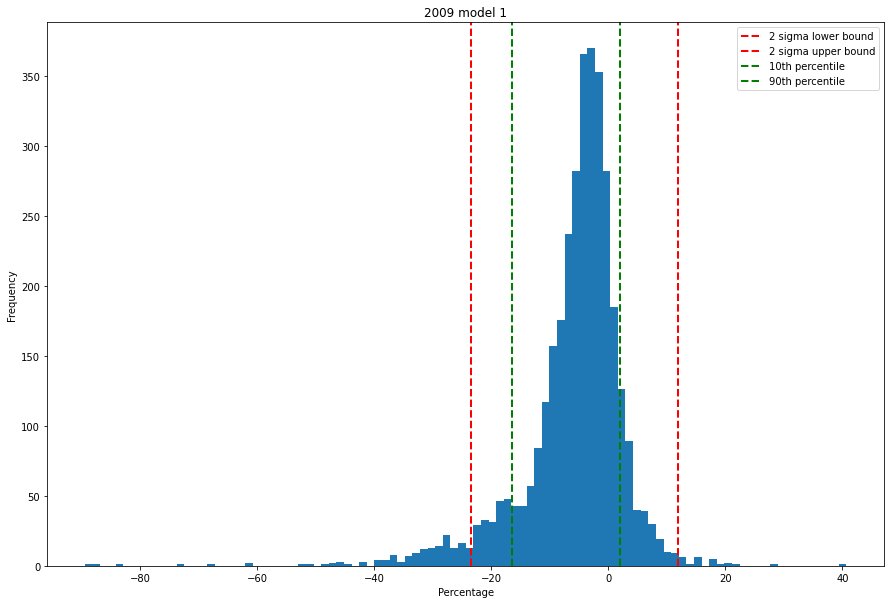

In [17]:
#drop NaN values
data = df_2009['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 model 1')

plt.show()

mean  2.311 std 11.932
2 sigma  -0.120 and 0.124
The percentage of companies outside 2 sigma is 99.505%


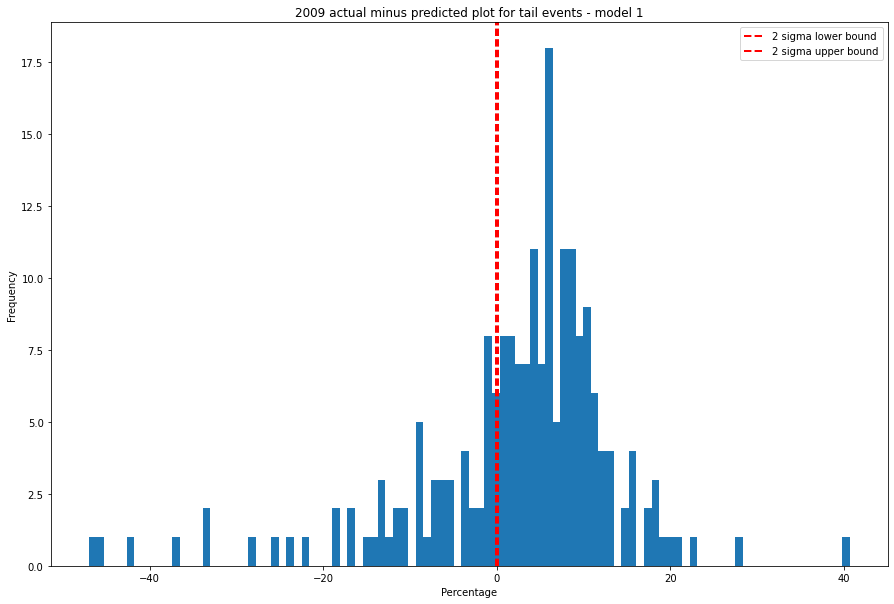

In [10]:
# Drop NaN values
tail_data = tail_data_2009['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 actual minus predicted plot for tail events - model 1')
plt.show()

### 2009 model 2

mean -0.969 std 8.075
2 sigma -17.119 and 15.181
The percentage of companies outside 2 sigma is 5.629%
The 10th percentile point is -9.306
The 90th percentile point is 5.828


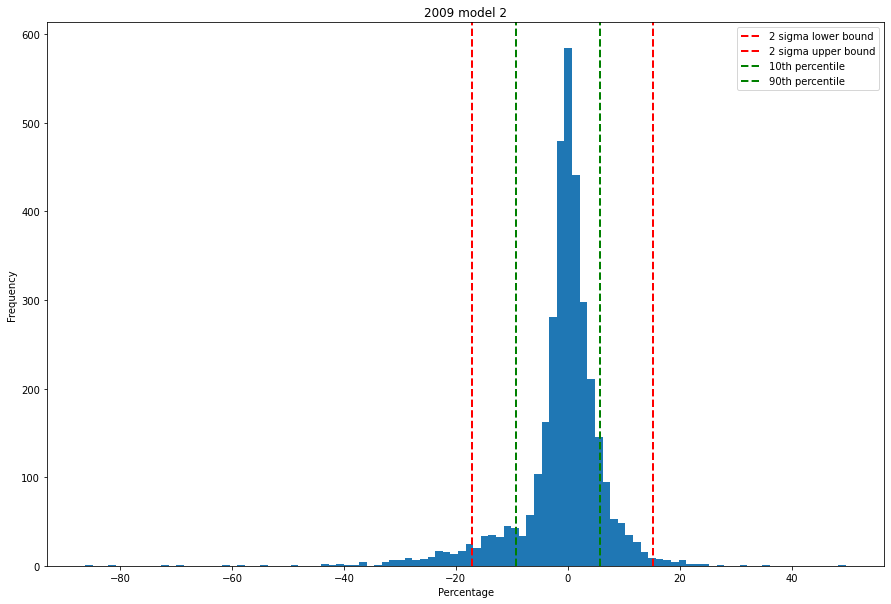

In [58]:
#drop NaN values
data = df_2009['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 model 2')

plt.show()

mean  9.167 std 10.944
2 sigma  -17.119 and 15.181
The percentage of companies outside 2 sigma is 22.277%


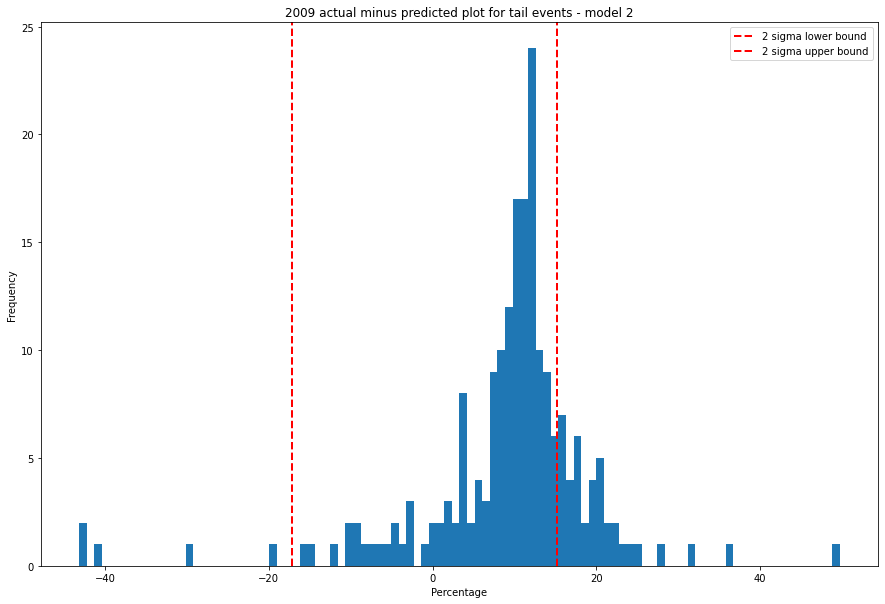

In [59]:
# Drop NaN values
tail_data = tail_data_2009['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 actual minus predicted plot for tail events - model 2')
plt.show()

# 2014 Analysis

In [13]:
df_2014['vol_difference'] = df_2014['impvol_1month_ATM'] - df_2014['impvol_6month_ATM']
positive_count = (df_2014['vol_difference'] > 0).sum()
print("Number of positive numbers:", positive_count)

Number of positive numbers: 4502


In [14]:
df_2014['actual-predicted_model1'] = df_2014.apply(
    lambda row:  abs(row['log_returns']*100) - (np.sqrt(2/math.pi)* ((np.sqrt((row['impvol_1month_ATM']**2) - (row['impvol_6month_ATM']**2))) * np.sqrt(1/12)))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2014['actual-predicted_model2'] = df_2014.apply(
    lambda row:  abs(row['log_returns']*100) - (row['vol_difference'] * np.sqrt(1/12))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2014

,event_id,company_id,stock_symbol,company_name,announce_datetime,fiscal_year,quarter,quarter_end_date,currency,amount_oc,time_class,announce_date,log_returns,impvol_1month_ATM,impvol_6month_ATM,vol_difference,actual-predicted_model1,actual-predicted_model2
0,3NN7ACWR,1495,LXK,Lexmark International Inc,2014-01-28 06:30:00,2013,Q4,12/31/2013,USD,1.18,BMO,2014-01-28,0.058939,42.1918,33.5900,8.6018,0.011710,3.410742
1,3NN7C2EP,2051,PCH,Potlatch Corporation,2014-01-28 06:30:00,2013,Q4,12/31/2013,USD,0.34,BMO,2014-01-28,-0.009631,25.1597,23.7643,1.3954,-0.940485,0.560272
2,3NN79303,1460,KLIC,Kulicke and Soffa Industries Inc,2014-01-28 06:55:00,2014,Q1,12/28/2013,USD,-0.03,BMO,2014-01-28,0.049672,38.1332,33.2336,4.8996,0.659039,3.552768
3,3NN7C0CO,6473,OSK,Oshkosh Corporation,2014-01-28 07:00:00,2014,Q1,12/31/2013,USD,0.63,BMO,2014-01-28,0.067500,43.8354,30.4455,13.3899,-0.515808,2.884717
4,3NN7EEIZ,1985,WAT,Waters Corporation,2014-01-28 07:00:00,2013,Q4,12/31/2013,USD,1.70,BMO,2014-01-28,0.057590,32.6126,24.6816,7.9310,0.847923,3.469541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,3NN74M5M,1431684339,ARE,Alexandria Real Estate Equities Inc.,2014-11-03 08:30:00,2014,Q3,09/30/2014,USD,1.20,BMO,2014-11-03,0.002887,14.6147,15.6158,-1.0011,NaN,NaN
4985,3NN76ZJK,9929,DXPE,DXP Enterprises Inc,2014-11-03 16:00:00,2014,Q3,09/30/2014,USD,1.14,AMC,2014-11-03,0.022990,73.1855,43.8100,29.3755,-11.207360,-6.181025
4986,3NN7DXQA,2542,SYKE,Sykes Enterprises Incorporated,2014-11-03 16:00:00,2014,Q3,09/30/2014,USD,0.45,AMC,2014-11-03,0.063808,47.6673,43.1793,4.4880,1.728805,5.085237
4987,3NN7CIVG,1431686046,SBRA,Sabra Health Care REIT Inc,2014-11-03 16:00:00,2014,Q3,09/30/2014,USD,0.60,AMC,2014-11-03,0.032509,23.9773,23.9773,0.0000,NaN,NaN


mean -0.001 std 0.046
2 sigma -0.092 and 0.091
The percentage of companies outside 2 sigma is 5.874%
The 10th percentile point is -0.048
The 90th percentile point is 0.046


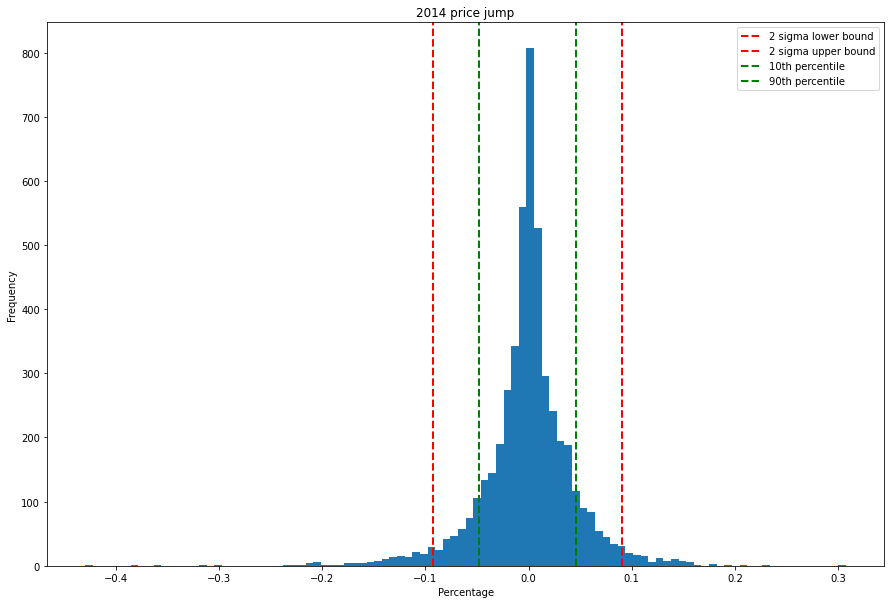

In [71]:
#drop NaN values
data = df_2014['log_returns'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Create a df with only the tail events
events_outside_2_sigma = outside_2_sigma.tolist()
tail_data_2014 = df_2014[df_2014['log_returns'].isin(outside_2_sigma)]

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 price jump')

plt.show()

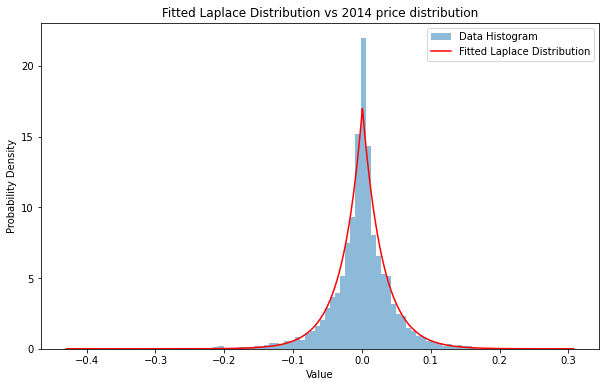

Kolmogorov-Smirnov Test:
KS Statistic: 0.037
P-value: 0.000
Mean Squared Error (MSE): 108.345


In [72]:
loc, scale = stats.laplace.fit(data)
plt.figure(figsize=(10, 6))
plt.hist(data, bins=100, density=True, alpha=0.5, label="Data Histogram")
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.pdf(x, loc=loc, scale=scale)

plt.plot(x, laplace_dist, 'r', label="Fitted Laplace Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Fitted Laplace Distribution vs 2014 price distribution")
plt.legend()
plt.show()

#Performing Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = stats.kstest(data, 'laplace', args=(loc, scale))
print("Kolmogorov-Smirnov Test:")
print(f"KS Statistic: {ks_statistic:.3f}")
print(f"P-value: {ks_p_value:.3f}")

#Calculate the Mean Squared Error
fitted_values = stats.laplace.pdf(data, loc=loc, scale=scale)
mse = np.mean((data - fitted_values) ** 2)

print(f"Mean Squared Error (MSE): {mse:.3f}")

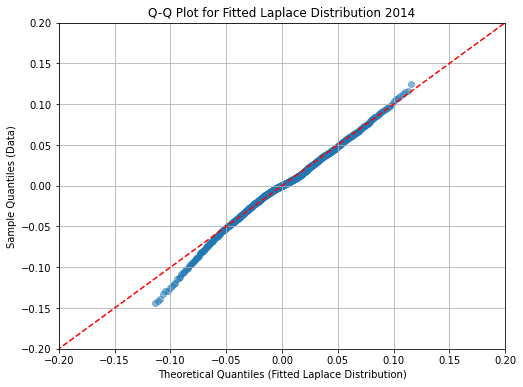

In [73]:
#Fiting the Laplace distribution to the data
loc, scale = stats.laplace.fit(data)

#Generate values for the fitted Laplace distribution
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.ppf(np.linspace(0.01, 0.99, 1000), loc=loc, scale=scale)

quantiles_data = np.percentile(data, np.linspace(1, 99, 1000))

#Plot the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(laplace_dist, quantiles_data, alpha=0.5)
plt.plot([np.min(data), np.max(data)], [np.min(data), np.max(data)], 'r--')
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Theoretical Quantiles (Fitted Laplace Distribution)')
plt.ylabel('Sample Quantiles (Data)')
plt.title('Q-Q Plot for Fitted Laplace Distribution 2014')
plt.grid(True)
plt.show()

### 2014 model 1 

mean -4.510 std 8.172
2 sigma -20.854 and 11.834
The percentage of companies outside 2 sigma is 4.109%
The 10th percentile point is -12.208
The 90th percentile point is 1.550


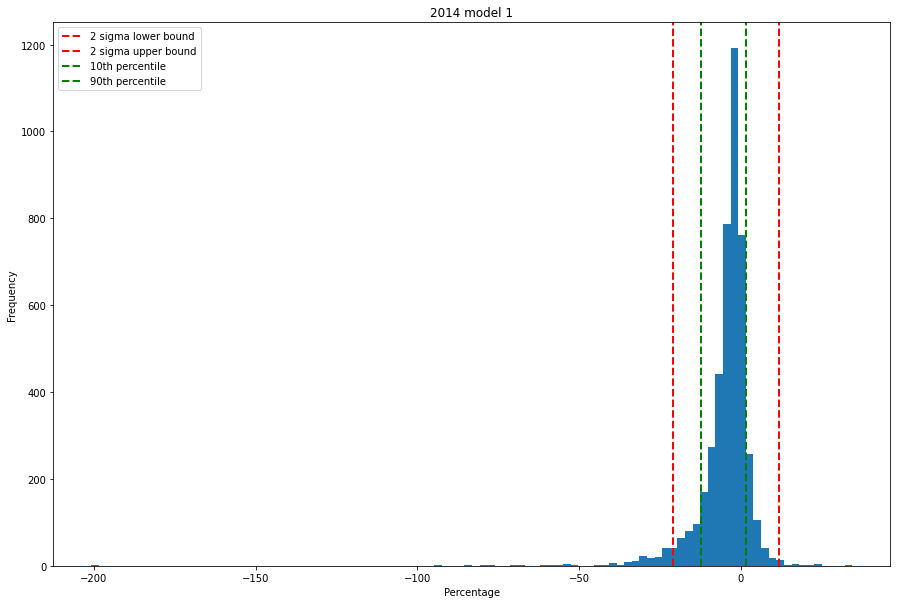

In [74]:
#drop NaN values
data = df_2014['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 model 1')

plt.show()

mean  1.816 std 10.351
2 sigma  -20.854 and 11.834
The percentage of companies outside 2 sigma is 12.014%


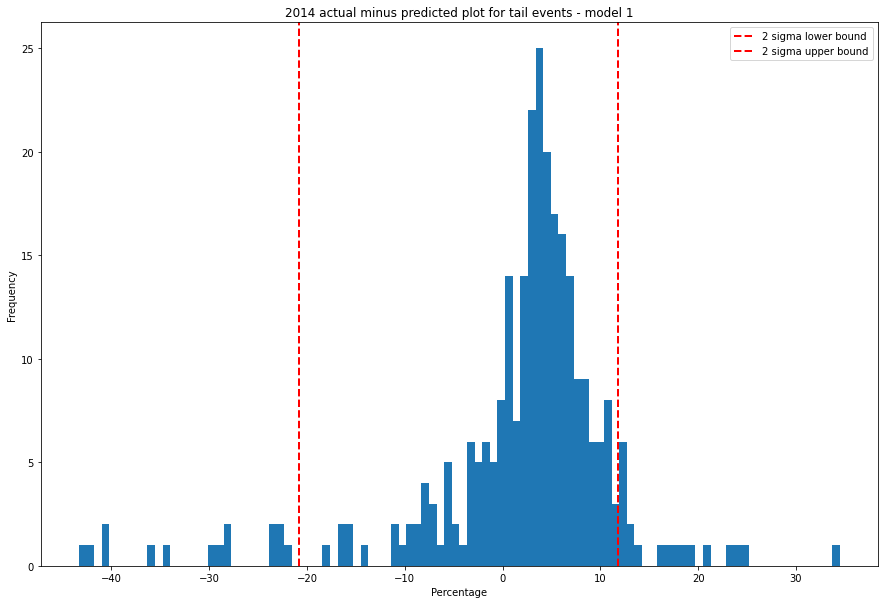

In [75]:
# Drop NaN values
tail_data = tail_data_2014['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 actual minus predicted plot for tail events - model 1')
plt.show()

### 2014 model 2

mean -1.897 std 8.539
2 sigma -18.975 and 15.182
The percentage of companies outside 2 sigma is 4.131%
The 10th percentile point is -9.192
The 90th percentile point is 3.983


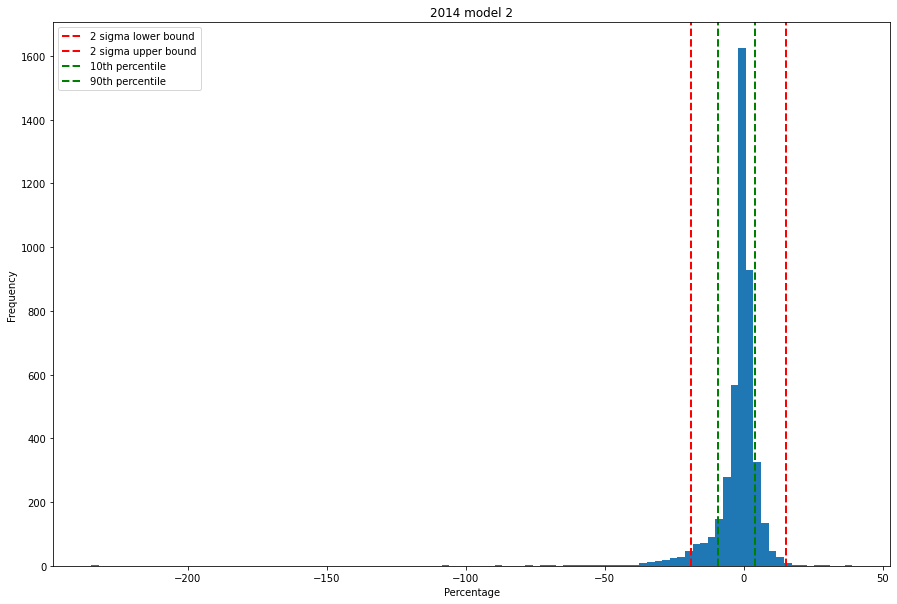

In [76]:
#drop NaN values
data = df_2014['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 model 2')

plt.show()

mean  5.477 std 10.817
2 sigma  -18.975 and 15.182
The percentage of companies outside 2 sigma is 12.014%


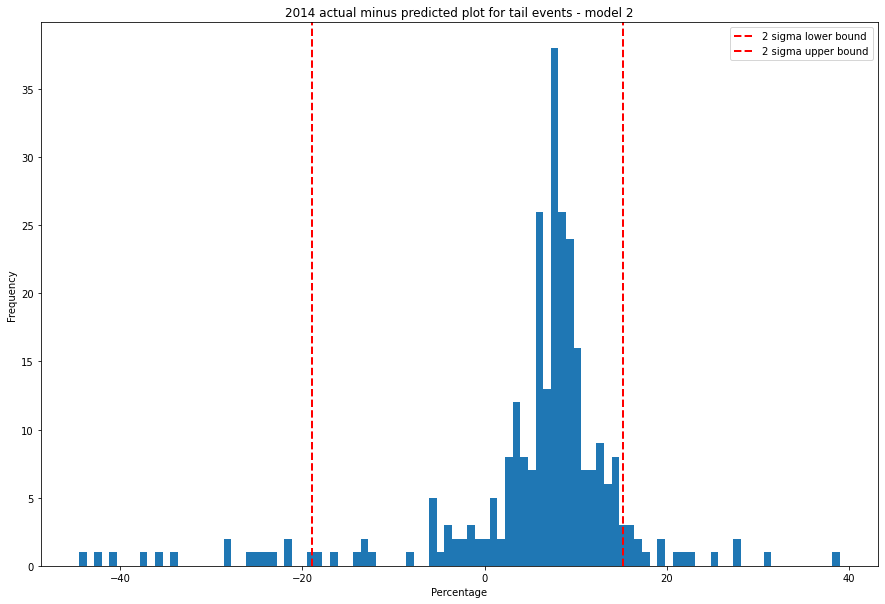

In [77]:
# Drop NaN values
tail_data = tail_data_2014['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 actual minus predicted plot for tail events - model 2')
plt.show()

# 2019 Analysis

In [15]:
df_2019['vol_difference'] = df_2019['impvol_1month_ATM'] - df_2019['impvol_6month_ATM']
positive_count = (df_2019['vol_difference'] > 0).sum()
print("Number of positive numbers:", positive_count)

Number of positive numbers: 4103


In [18]:
df_2019['actual-predicted_model1'] = df_2019.apply(
    lambda row:  abs(row['log_returns']*100) - (np.sqrt(2/math.pi)* ((np.sqrt((row['impvol_1month_ATM']**2) - (row['impvol_6month_ATM']**2))) * np.sqrt(1/12)))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2019['actual-predicted_model2'] = df_2019.apply(
    lambda row:  abs(row['log_returns']*100) - (row['vol_difference'] * np.sqrt(1/12))
    if row['vol_difference'] > 0 else np.nan, axis=1)

df_2019

,event_id,company_id,stock_symbol,isin,company_name,announce_datetime,fiscal_year,quarter,quarter_end_date,currency,time_class,announce_date,log_returns,impvol_1month_ATM,impvol_6month_ATM,vol_difference,actual-predicted_model1,actual-predicted_model2
0,3VOH046Q,1431693068,SMPL,US82900L1026,The Simply Good Foods Company,2019-01-03 07:00:00,2019,Q1,11/24/2018,USD,BMO,2019-01-03,0.055152,64.2479,44.6513,19.5966,-5.125076,-0.141869
1,3VNW03VA,2225,RPM,US7496851038,RPM International Inc.,2019-01-04 06:45:00,2019,Q2,11/30/2018,USD,BMO,2019-01-04,-0.004105,42.6408,27.4541,15.1867,-7.104453,-3.973555
2,3VLS03V1,1431683023,ANGO,US03475V1017,AngioDynamics Inc.,2019-01-04 07:00:00,2019,Q2,11/30/2018,USD,BMO,2019-01-04,0.035765,68.0880,36.3143,31.7737,-9.689468,-5.595795
3,3VOI040N,670,CMC,US2017231034,Commercial Metals Co.,2019-01-07 06:45:00,2019,Q1,11/30/2018,USD,BMO,2019-01-07,0.068677,69.0623,41.4289,27.6334,-5.859442,-1.109389
4,3VQL04E8,1431684442,TEL,CH0102993182,TE Connectivity Ltd.,2019-01-23 06:00:00,2019,Q1,12/28/2018,USD,BMO,2019-01-23,-0.031700,27.9183,23.5660,4.3523,-0.277834,1.913599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336,43E8042T,1431685785,KNX,US4990491049,Knight-Swift Transportation Holdings Inc.,2020-01-29,2019,Q4,12/31/2019,USD,BMO,2020-01-29,0.067886,41.6709,37.3426,4.3283,2.529105,5.539134
4337,43DO03VJ,1431692060,SGH,KYG8232Y1017,"SMART Global Holdings, Inc.",2019-12-19 16:05:00,2020,Q1,11/29/2019,USD,AMC,2019-12-19,-0.037930,264.3048,54.7000,209.6048,-55.766191,-56.714712
4338,43BH03VT,1790,NKE,US6541061031,Nike Inc.,2019-12-19 16:15:00,2020,Q2,11/30/2019,USD,AMC,2019-12-19,-0.001484,101.9178,22.9935,78.9243,-22.721042,-22.635078
4339,43GD04J4,2862,X,US9129091081,United States Steel Corp.,2020-01-29 16:00:00,2019,Q4,12/31/2019,USD,AMC,2020-01-29,-0.004301,69.0970,54.8683,14.2287,-9.243358,-3.677363


mean -0.008 std 0.104
2 sigma -0.216 and 0.201
The percentage of companies outside 2 sigma is 5.275%
The 10th percentile point is -0.118
The 90th percentile point is 0.083


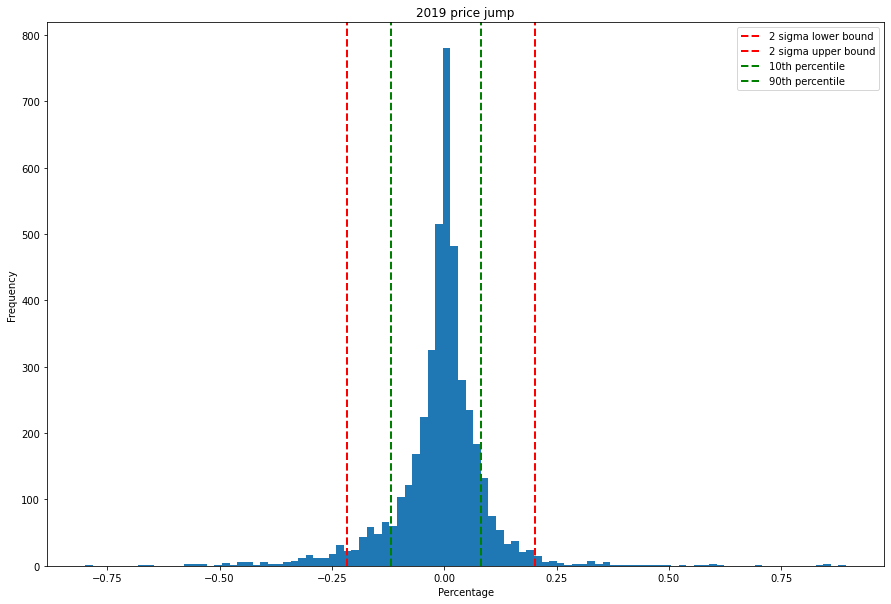

In [87]:
#drop NaN values
data = df_2019['log_returns'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Create a df with only the tail events
events_outside_2_sigma = outside_2_sigma.tolist()
tail_data_2019 = df_2019[df_2019['log_returns'].isin(outside_2_sigma)]

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 price jump')

plt.show()

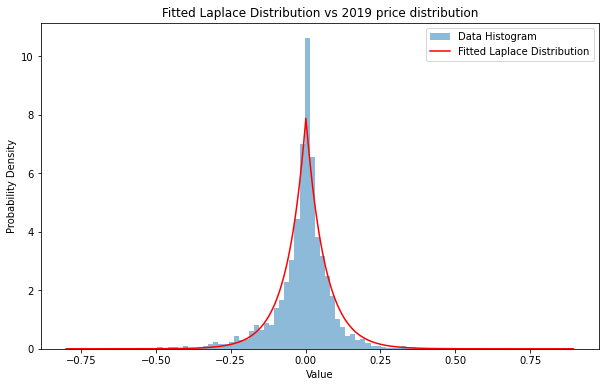

Kolmogorov-Smirnov Test:
KS Statistic: 0.051
P-value: 0.000
Mean Squared Error (MSE): 24.103


In [88]:
loc, scale = stats.laplace.fit(data)
plt.figure(figsize=(10, 6))
plt.hist(data, bins=100, density=True, alpha=0.5, label="Data Histogram")
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.pdf(x, loc=loc, scale=scale)

plt.plot(x, laplace_dist, 'r', label="Fitted Laplace Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Fitted Laplace Distribution vs 2019 price distribution")
plt.legend()
plt.show()

#Performing Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = stats.kstest(data, 'laplace', args=(loc, scale))
print("Kolmogorov-Smirnov Test:")
print(f"KS Statistic: {ks_statistic:.3f}")
print(f"P-value: {ks_p_value:.3f}")

#Calculate the Mean Squared Error
fitted_values = stats.laplace.pdf(data, loc=loc, scale=scale)
mse = np.mean((data - fitted_values) ** 2)

print(f"Mean Squared Error (MSE): {mse:.3f}")

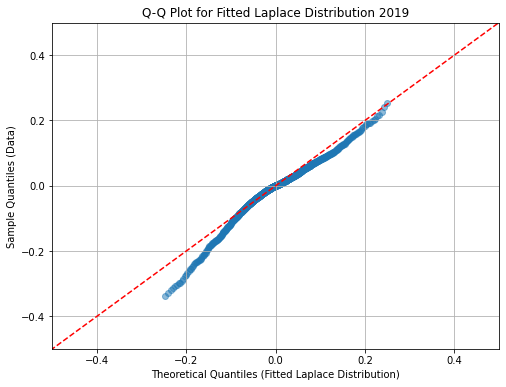

In [90]:
#Fiting the Laplace distribution to the data
loc, scale = stats.laplace.fit(data)

#Generate values for the fitted Laplace distribution
x = np.linspace(np.min(data), np.max(data), 1000)
laplace_dist = stats.laplace.ppf(np.linspace(0.01, 0.99, 1000), loc=loc, scale=scale)

quantiles_data = np.percentile(data, np.linspace(1, 99, 1000))

#Plot the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(laplace_dist, quantiles_data, alpha=0.5)
plt.plot([np.min(data), np.max(data)], [np.min(data), np.max(data)], 'r--')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('Theoretical Quantiles (Fitted Laplace Distribution)')
plt.ylabel('Sample Quantiles (Data)')
plt.title('Q-Q Plot for Fitted Laplace Distribution 2019')
plt.grid(True)
plt.show()

### 2019 model 1

mean -2.668 std 10.433
2 sigma -23.533 and 18.198
The percentage of companies outside 2 sigma is 5.874%
The 10th percentile point is -12.688
The 90th percentile point is 6.345


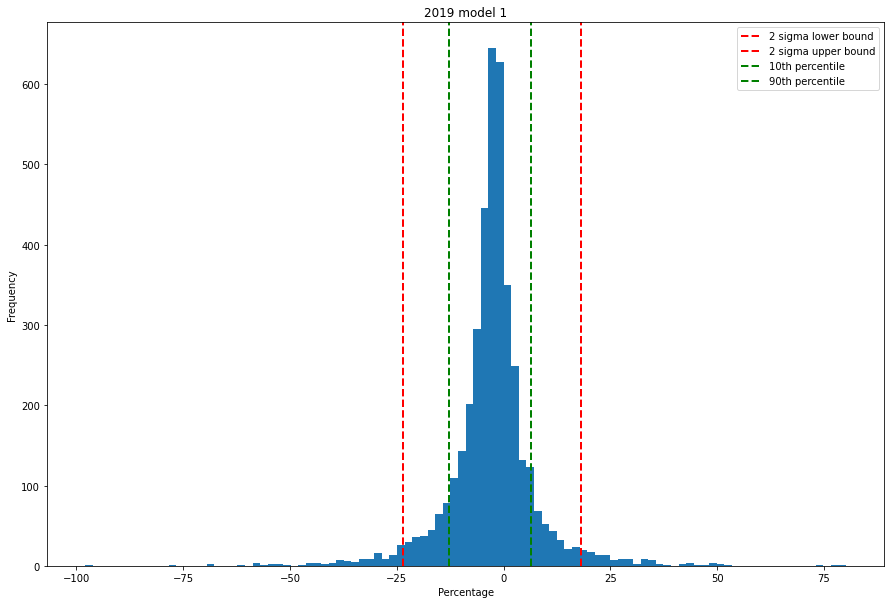

In [91]:
#drop NaN values
data = df_2019['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 model 1')

plt.show()

mean  20.334 std 13.762
2 sigma  -23.533 and 18.198
The percentage of companies outside 2 sigma is 55.204%


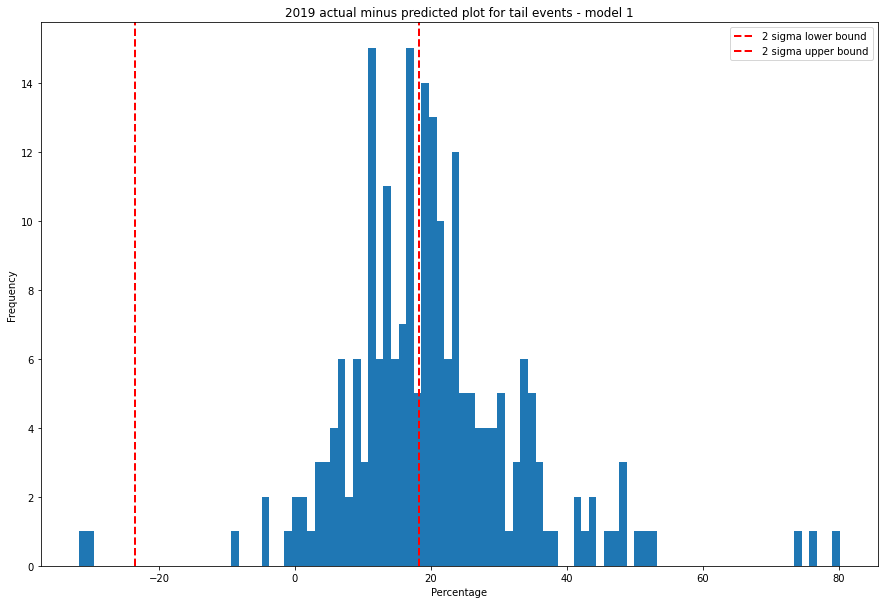

In [92]:
# Drop NaN values
tail_data = tail_data_2019['actual-predicted_model1'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 actual minus predicted plot for tail events - model 1')
plt.show()

### 2019 model 2

mean 0.432 std 10.841
2 sigma -21.249 and 22.113
The percentage of companies outside 2 sigma is 5.922%
The 10th percentile point is -9.110
The 90th percentile point is 9.834


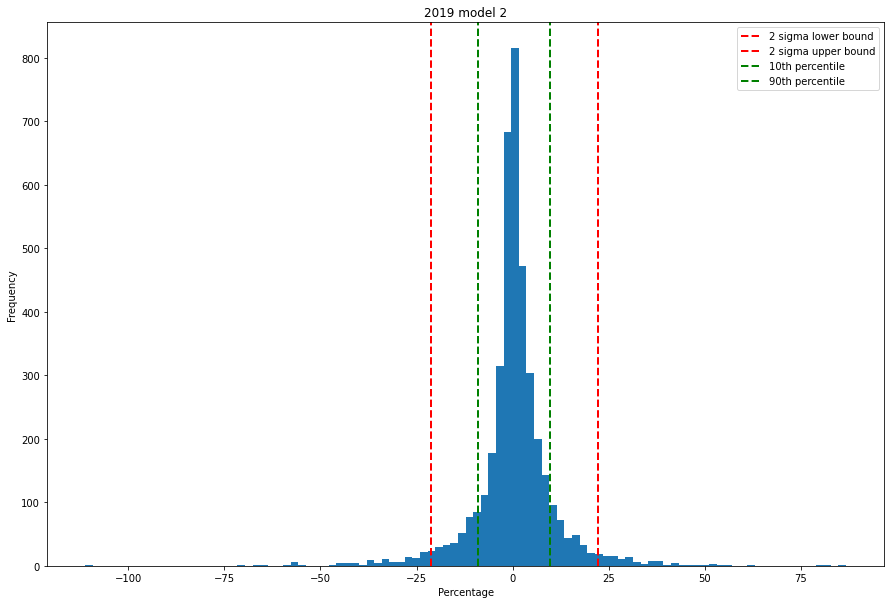

In [93]:
#drop NaN values
data = df_2019['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = data[(data < lower_bound) | (data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(data)) * 100
percentile_10 = np.percentile(data, 10)
percentile_90 = np.percentile(data, 90)

print(f"mean {mean:.3f} std {std_dev:.3f}")
print(f"2 sigma {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")
print(f"The 10th percentile point is {percentile_10:.3f}")
print(f"The 90th percentile point is {percentile_90:.3f}")

#Plot histogram
plt.figure(figsize=(15, 10))
plt.hist(data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_10, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=2)

plt.legend(['2 sigma lower bound', '2 sigma upper bound', '10th percentile', '90th percentile'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 model 2')

plt.show()

mean  24.936 std 13.337
2 sigma  -21.249 and 22.113
The percentage of companies outside 2 sigma is 52.489%


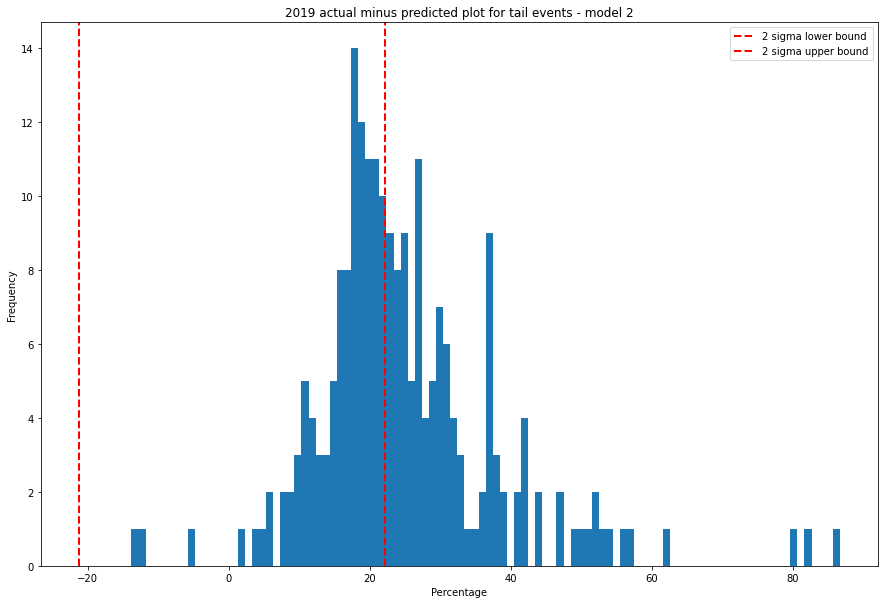

In [94]:
# Drop NaN values
tail_data = tail_data_2019['actual-predicted_model2'].dropna()

mean = data.mean()
std_dev = data.std()
tail_mean = tail_data.mean()
tail_std_dev = tail_data.std()
lower_bound = mean - 2*std_dev
upper_bound = mean + 2*std_dev
outside_2_sigma = tail_data[(tail_data < lower_bound) | (tail_data > upper_bound)]
percentage_outside_2_sigma = (len(outside_2_sigma) / len(tail_data)) * 100

print(f"mean  {tail_mean:.3f} std {tail_std_dev:.3f}")
print(f"2 sigma  {lower_bound:.3f} and {upper_bound:.3f}")
print(f"The percentage of companies outside 2 sigma is {percentage_outside_2_sigma:.3f}%")

#plot histogram
plt.figure(figsize=(15, 10))
plt.hist(tail_data, bins=100)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)
plt.legend(['2 sigma lower bound', '2 sigma upper bound'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 actual minus predicted plot for tail events - model 2')
plt.show()

# Model Comparison

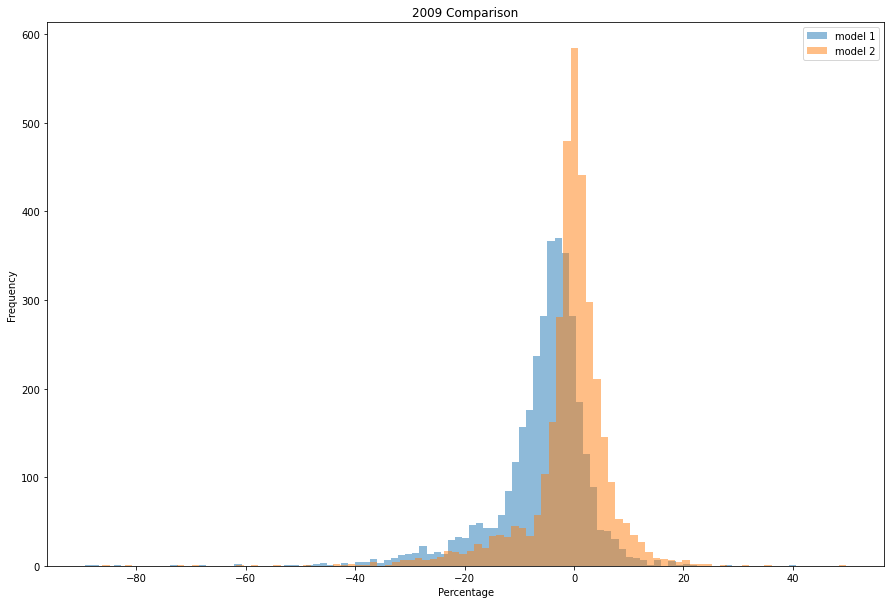

In [112]:
plt.figure(figsize=(15, 10))
plt.hist(df_2009['actual-predicted_model1'], bins=100, alpha=0.5, label='model 1')
plt.hist(df_2009['actual-predicted_model2'], bins=100, alpha=0.5, label="model 2")

plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2009 Comparison')
plt.legend(loc='upper right')

plt.show()

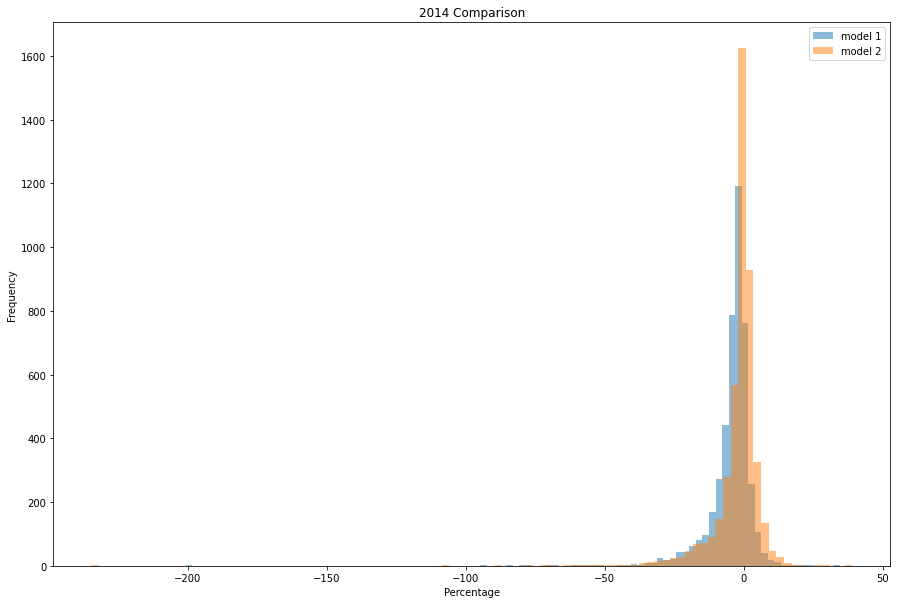

In [113]:
plt.figure(figsize=(15, 10))
plt.hist(df_2014['actual-predicted_model1'], bins=100, alpha=0.5, label='model 1')
plt.hist(df_2014['actual-predicted_model2'], bins=100, alpha=0.5, label="model 2")

plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2014 Comparison')
plt.legend(loc='upper right')

plt.show()

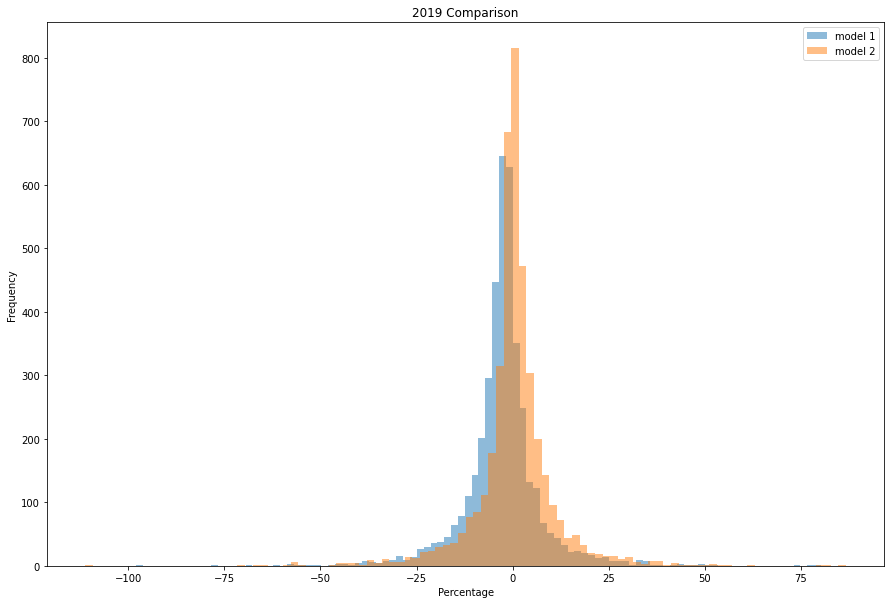

In [114]:
plt.figure(figsize=(15, 10))
plt.hist(df_2019['actual-predicted_model1'], bins=100, alpha=0.5, label='model 1')
plt.hist(df_2019['actual-predicted_model2'], bins=100, alpha=0.5, label="model 2")

plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('2019 Comparison')
plt.legend(loc='upper right')

plt.show()